# **About the Dataset**

**Context**
The rise of "fake news" has become a significant challenge in maintaining quality journalism and ensuring the public has access to reliable information. In response, the Fake News Challenge, launched in early 2017, aimed to promote the development of machine learning-based classification systems for "stance detection." The goal of stance detection is to determine whether a specific news headline "agrees," "disagrees," "discusses," or is "unrelated" to a particular news article. This would help journalists and others more efficiently identify and investigate potential instances of fake news.

**Content**

The dataset consists of instances that include the headline, body of the article, and stance. The stance can take one of the following values: {unrelated, discuss, agree, disagree}. The dataset is split into two CSV files:

1. **train\_bodies.csv**
   This file contains the body text of articles, labeled as `articleBody`, with corresponding IDs (`Body ID`).

2. **train\_stances.csv**
   This file contains the labeled stance values, where the `Stance` column indicates the relationship between article headlines (`Headline`) and the article bodies (identified by `Body ID` from `train_bodies.csv`).

**Distribution of the Data**

The stance classes in `train_stances.csv` are distributed as follows:

| Rows  | Unrelated | Discuss | Agree  | Disagree |
| ----- | --------- | ------- | ------ | -------- |
| 49972 | 0.73131   | 0.17828 | 0.0736 | 0.01681  |

There are four possible classifications:

1. **Agree**: The article text agrees with the headline.
2. **Disagree**: The article text disagrees with the headline.
3. **Discuss**: The article text discusses the headline without taking a position.
4. **Unrelated**: The article text is unrelated to the headline (i.e., it doesn't address the same topic).

**Acknowledgements**

For more information about the task, visit [FakeNewsChallenge.org](https://www.fakenewschallenge.org/).




In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"omniaezzat","key":"d9db4bbe2be6a3295e30886dac547996"}'}

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d abhinavkrjha/fake-news-challenge

Dataset URL: https://www.kaggle.com/datasets/abhinavkrjha/fake-news-challenge
License(s): DbCL-1.0
  0% 0.00/5.09M [00:00<?, ?B/s]
100% 5.09M/5.09M [00:00<00:00, 749MB/s]


In [4]:
!unzip fake-news-challenge.zip

Archive:  fake-news-challenge.zip
  inflating: competition_test_bodies.csv  
  inflating: competition_test_stances_unlabeled.csv  
  inflating: test_bodies.csv         
  inflating: test_stances_unlabeled.csv  
  inflating: train_bodies.csv        
  inflating: train_stances.csv       


In [5]:

!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 24.2 MB/s eta 0:00:00


In [6]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.4 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from nltk.stem.porter import PorterStemmer
import re
import string
import nltk
import contractions
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import emoji
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [8]:
train_bodies=pd.read_csv('/content/train_bodies.csv')
train_stance=pd.read_csv('/content/train_stances.csv')


In [10]:
combined_df = pd.merge(train_stance, train_bodies, how='inner', on='Body ID')
combined_df.head()


,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1923,disagree,"Fear not arachnophobes, the story of Bunbury's..."


In [11]:
combined_df.drop(['Body ID'],axis=1,inplace=True)

In [12]:
df=combined_df.copy()

In [13]:
df.isna().sum()

,0
Headline,0
Stance,0
articleBody,0


In [14]:
df.duplicated().sum()

np.int64(434)

In [15]:
df.shape

(49972, 3)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headline     49972 non-null  object
 1   Stance       49972 non-null  object
 2   articleBody  49972 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [17]:
df.drop_duplicates(inplace=True)

# Visualization

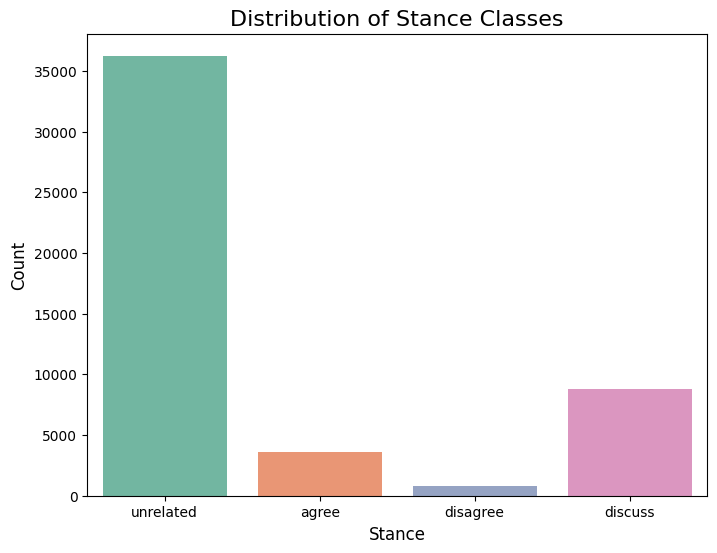

In [44]:

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Stance', palette='Set2')


plt.title('Distribution of Stance Classes', fontsize=16)
plt.xlabel('Stance', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


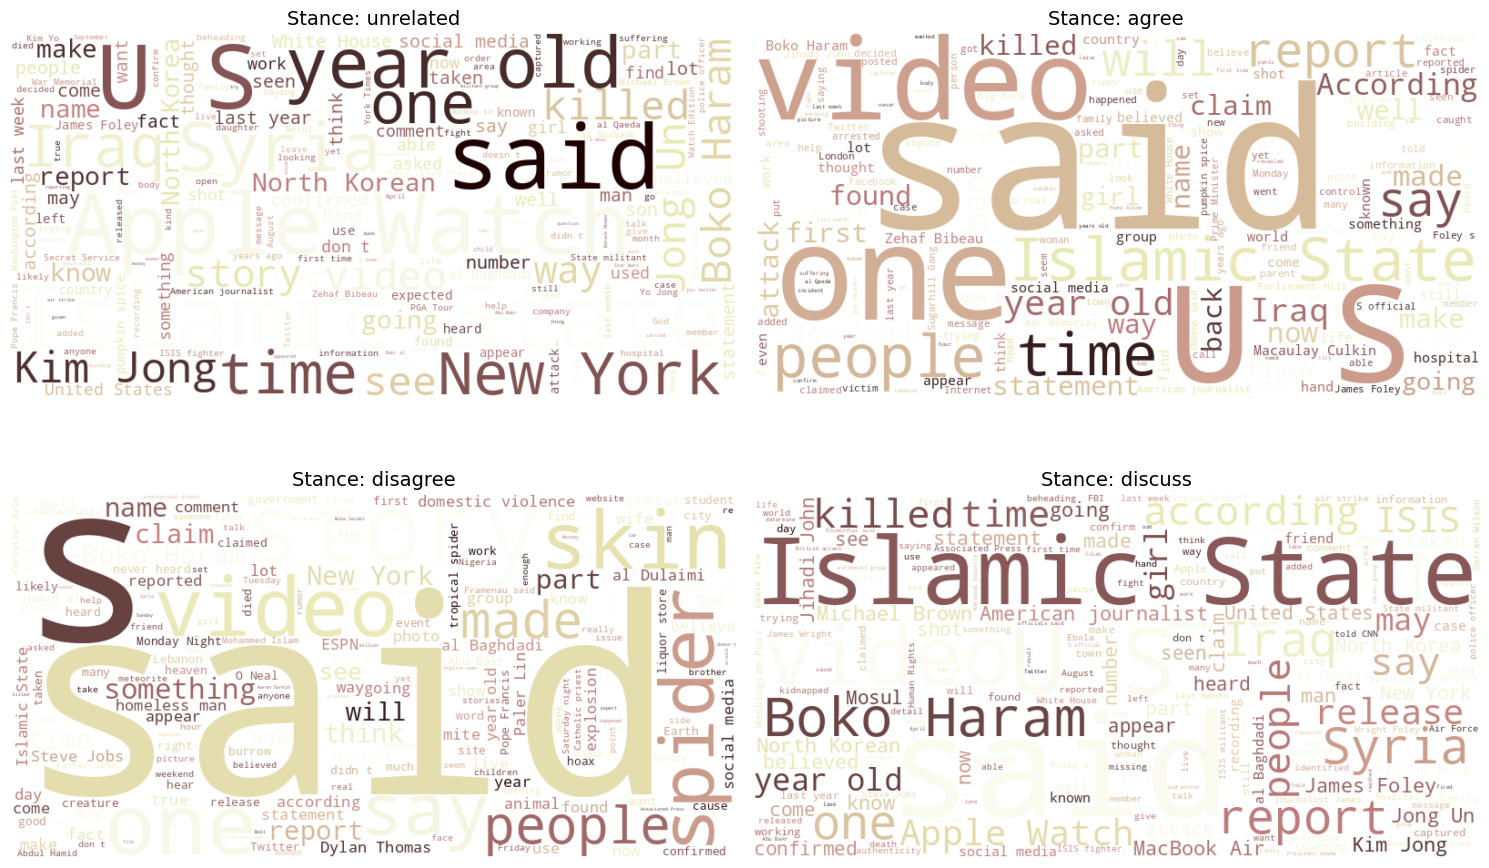

In [46]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

stances = combined_df['Stance'].unique()
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
colors = ["#fbb1bd", "#f7c5cc", "#f28482", "#fb6f92"]

for i, stance in enumerate(stances):
    stance_df = combined_df[combined_df['Stance'] == stance]
    text = ' '.join(stance_df['articleBody'])

    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          colormap='pink').generate(text)

    ax = axes[i//2, i%2]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'Stance: {stance}', fontsize=14)

plt.tight_layout()
plt.show()


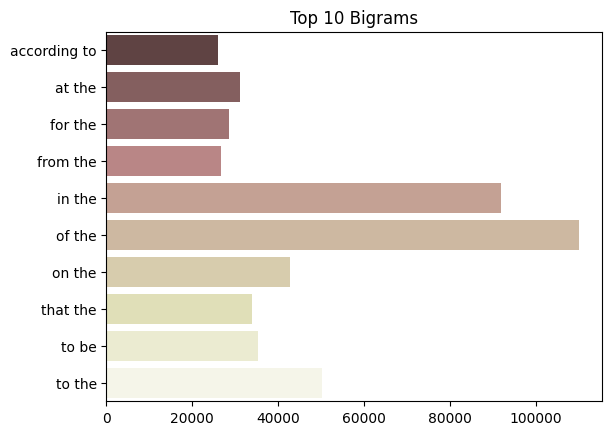

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

vec = CountVectorizer(ngram_range=(2, 2), max_features=10)
X = vec.fit_transform(combined_df['articleBody'])
bigrams = vec.get_feature_names_out()

counts = X.toarray().sum(axis=0)

sns.barplot(x=counts, y=bigrams, palette='pink')
plt.title("Top 10 Bigrams")
plt.show()


In [20]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re, string, emoji, contractions

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = contractions.fix(text)
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r"http\S+|www\S+", '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
df['articleBody'] = df['articleBody'].apply(clean_text)
df["Headline"] = df["Headline"].apply(clean_text)

In [22]:
df.head()

,Headline,Stance,articleBody
0,police find mass graf least body near mexico t...,unrelated,danny boyle directing untitled film seth rogen...
1,hundred palestinian flee flood gaza israel ope...,agree,hundred palestinian evacuated home sunday morn...
2,christian bale pass role steve job actor repor...,unrelated,yearold moscow resident hospitalized wound int...
3,hbo apple talk month apple streaming service l...,unrelated,reuters canadian soldier shot canadian war mem...
4,spider burrowed tourist stomach chest,disagree,fear arachnophobes story bunburys spiderman mi...


In [23]:
X = df['Headline'] + " " + df['articleBody']

In [24]:
len(X[0])

821

In [25]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['Stance_Encoded'] = label_encoder.fit_transform(df['Stance'])


In [26]:
y=df['Stance_Encoded']

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


max_words = 10000
max_len = 1000

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
ا
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 classes

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.build(input_shape=(None, 100))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 96, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,370,564 (5.23 MB)

 Trainable params: 1,370,564 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))


Epoch 1/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 504s 810ms/step - accuracy: 0.7370 - loss: 0.7614 - val_accuracy: 0.8035 - val_loss: 0.5317
Epoch 2/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 539s 774ms/step - accuracy: 0.8211 - loss: 0.5025 - val_accuracy: 0.8422 - val_loss: 0.4193
Epoch 3/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 491s 757ms/step - accuracy: 0.8620 - loss: 0.3806 - val_accuracy: 0.8758 - val_loss: 0.3349
Epoch 4/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 481s 723ms/step - accuracy: 0.8921 - loss: 0.2778 - val_accuracy: 0.9055 - val_loss: 0.2533
Epoch 5/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 510s 737ms/step - accuracy: 0.9226 - loss: 0.2072 - val_accuracy: 0.9177 - val_loss: 0.2247


In [32]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

310/310 ━━━━━━━━━━━━━━━━━━━━ 36s 115ms/step - accuracy: 0.9150 - loss: 0.2292
Test Accuracy: 0.9177


310/310 ━━━━━━━━━━━━━━━━━━━━ 29s 92ms/step


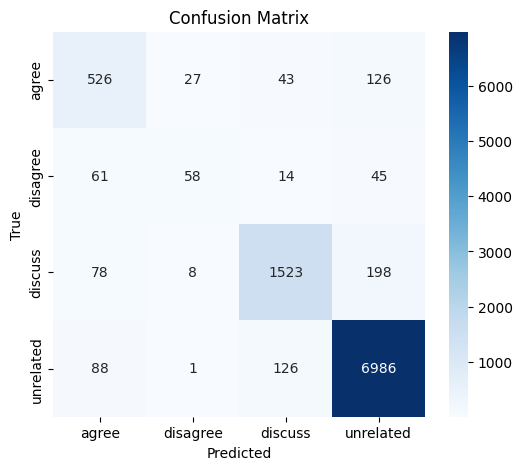

              precision    recall  f1-score   support

       agree       0.70      0.73      0.71       722
    disagree       0.62      0.33      0.43       178
     discuss       0.89      0.84      0.87      1807
   unrelated       0.95      0.97      0.96      7201

    accuracy                           0.92      9908
   macro avg       0.79      0.72      0.74      9908
weighted avg       0.92      0.92      0.92      9908



In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

In [38]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=10000, output_dim=128, input_length=max_len))
model_lstm.add(LSTM(128, return_sequences=False))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(4, activation='softmax'))


model_lstm.build(input_shape=(None, max_len))

model_lstm.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 1000, 128)      │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,420,100 (5.42 MB)

 Trainable params: 1,420,100 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
history_lstm = model_lstm.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=5,
    batch_size=64,
    verbose=1
)

Epoch 1/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 1496s 2s/step - accuracy: 0.7214 - loss: 0.8758 - val_accuracy: 0.7268 - val_loss: 0.8064
Epoch 2/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 1499s 2s/step - accuracy: 0.7350 - loss: 0.8063 - val_accuracy: 0.7270 - val_loss: 0.8066
Epoch 3/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 1495s 2s/step - accuracy: 0.7318 - loss: 0.8064 - val_accuracy: 0.7271 - val_loss: 0.8058
Epoch 4/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 1530s 2s/step - accuracy: 0.7337 - loss: 0.8004 - val_accuracy: 0.7272 - val_loss: 0.8051
Epoch 5/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 1571s 3s/step - accuracy: 0.7339 - loss: 0.7998 - val_accuracy: 0.7272 - val_loss: 0.8051
